# Modellierung & Dashboard-Vorbereitung

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
df = pd.read_csv("../candy-data.csv")

In [3]:
# Features & Target
X = df.drop(columns=['competitorname', 'winpercent'])
y = df['winpercent']

# # Train/Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



### Linear Regression

In [4]:
X_ols = df.drop(columns=['competitorname', 'winpercent'])  
y_ols = df['winpercent']  

X_ols = sm.add_constant(X_ols)

ols_model = sm.OLS(y_ols, X_ols).fit()

# Print summary table
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             winpercent   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     7.797
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           9.50e-09
Time:                        13:10:04   Log-Likelihood:                -315.64
No. Observations:                  85   AIC:                             655.3
Df Residuals:                      73   BIC:                             684.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               34.5340      4.320  

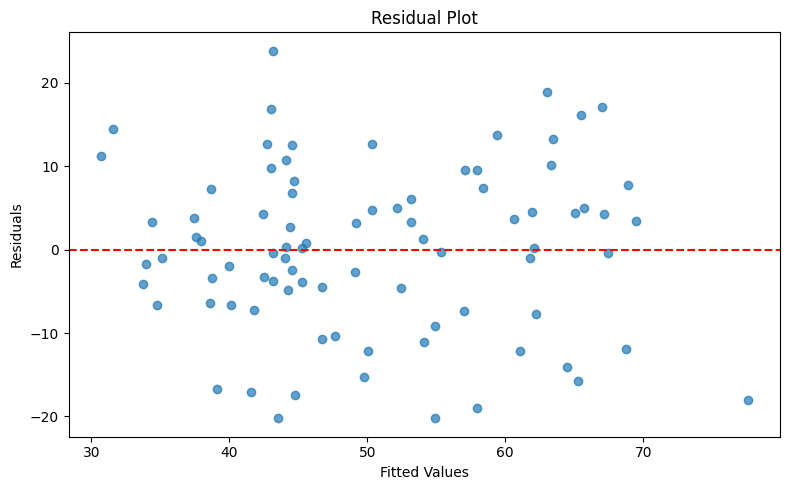

In [5]:
# Vorhersagen und Residuen
fitted_vals = ols_model.fittedvalues
residuals = ols_model.resid

# Plot: Fitted Values vs. Residuen
plt.figure(figsize=(8, 5))
plt.scatter(fitted_vals, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()

In [6]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Berechne Breusch-Pagan-Test
bp_test = het_breuschpagan(residuals, X_ols)

labels = ['LM Statistic', 'LM p-value', 'F-statistic', 'F p-value']
for label, value in zip(labels, bp_test):
    print(f"{label}: {value:.4f}")

LM Statistic: 14.5163
LM p-value: 0.2057
F-statistic: 1.3668
F p-value: 0.2071


In [7]:
df.columns

Index(['competitorname', 'chocolate', 'fruity', 'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'sugarpercent',
       'pricepercent', 'winpercent'],
      dtype='object')

In [8]:
df['chocolate_x_bar'] = df['chocolate'] * df['bar']

df['chocolate_x_crispedricewafer'] = df['chocolate'] * df['crispedricewafer']

# Restriktiertes Modell: nur Hauptwirkungen
X_main = df[
    ['chocolate', 'fruity', 'caramel', 'peanutyalmondy',
     'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'sugarpercent',
     'pricepercent']
]
X_main = sm.add_constant(X_main)
ols_main = sm.OLS(df['winpercent'], X_main).fit()

# Volles Modell: Hauptwirkungen + Interaktionen
X_int = df[
    ['chocolate', 'fruity', 'caramel', 'peanutyalmondy',
     'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'sugarpercent',
     'pricepercent', 'chocolate_x_bar', 'chocolate_x_crispedricewafer']
]
X_int = sm.add_constant(X_int)
ols_int = sm.OLS(df['winpercent'], X_int).fit()

# F-Test: Vergleich volles vs. eingeschränktes Modell
f_test_res = ols_int.compare_f_test(ols_main)

print(f"F-Statistik: {f_test_res[0]:.4f}")
print(f"p-Wert: {f_test_res[1]:.4f}")
print(f"df_diff: {f_test_res[2]}")

F-Statistik: 0.0077
p-Wert: 0.9305
df_diff: 1.0


### Decision Tree

R² scores (5-fold): [-0.03014946  0.12963427  0.18856273  0.14431306 -0.27084328]
Average R²: 0.032303466169463335
RMSE scores (5-fold): [154.76386726 139.58170888 153.36445726 242.32230172 204.17220339]
Average RMSE: 178.84090770221866


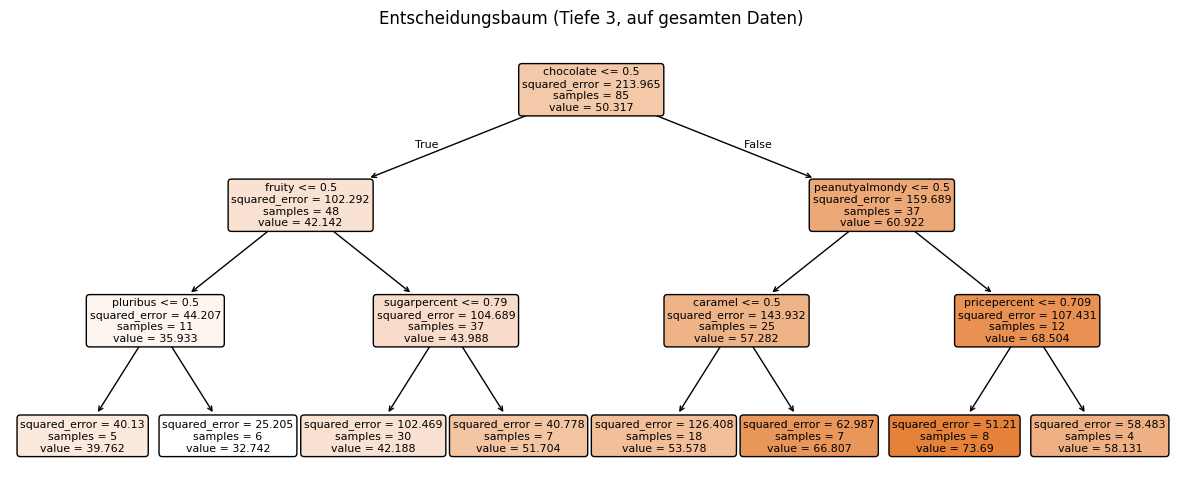

In [9]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor


# Define model
tree_model = DecisionTreeRegressor(max_depth=3, random_state=42)

# Define custom RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform 5-fold cross-validation
cv_results = cross_validate(
    tree_model,
    X,
    y,
    cv=5,
    scoring={'r2': 'r2', 'rmse': rmse_scorer},
    return_train_score=False
)

# Print metrics
print("R² scores (5-fold):", cv_results['test_r2'])
print("Average R²:", np.mean(cv_results['test_r2']))
print("RMSE scores (5-fold):", -cv_results['test_rmse'])  # negate because scorer returns negative
print("Average RMSE:", -np.mean(cv_results['test_rmse']))

# Optional: fit and plot one tree
tree_model.fit(X, y)
plt.figure(figsize=(15, 6))
plot_tree(tree_model, feature_names=X.columns, filled=True, rounded=True)
plt.title("Entscheidungsbaum (Tiefe 3, auf gesamten Daten)")
plt.show()

### Random Forest

R² Scores (per fold): [0.27324796 0.32062553 0.50372678 0.31406706 0.47299825]
Mean R² Score: 0.3769331131310021
Cross-validated RMSE: 125.53265708813584


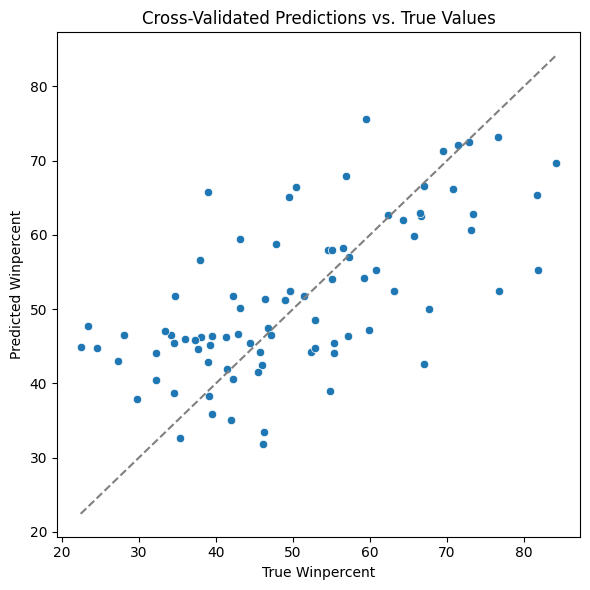

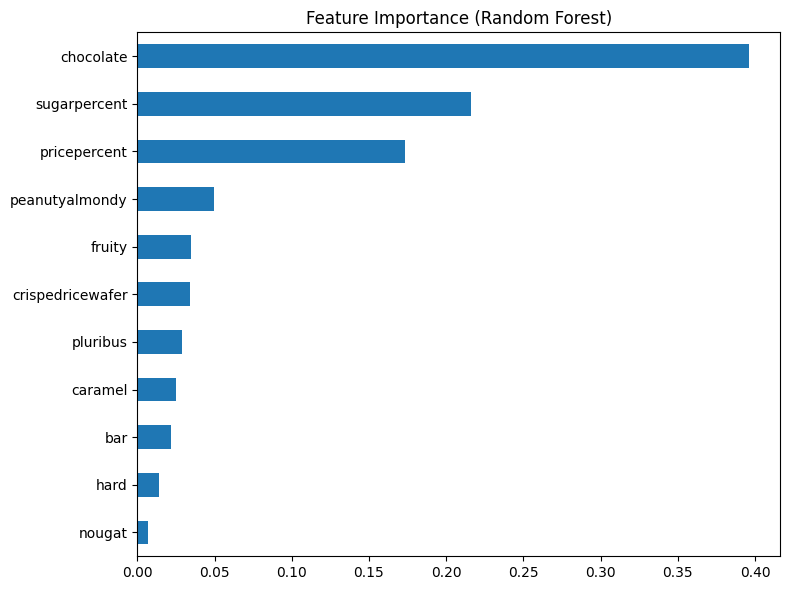

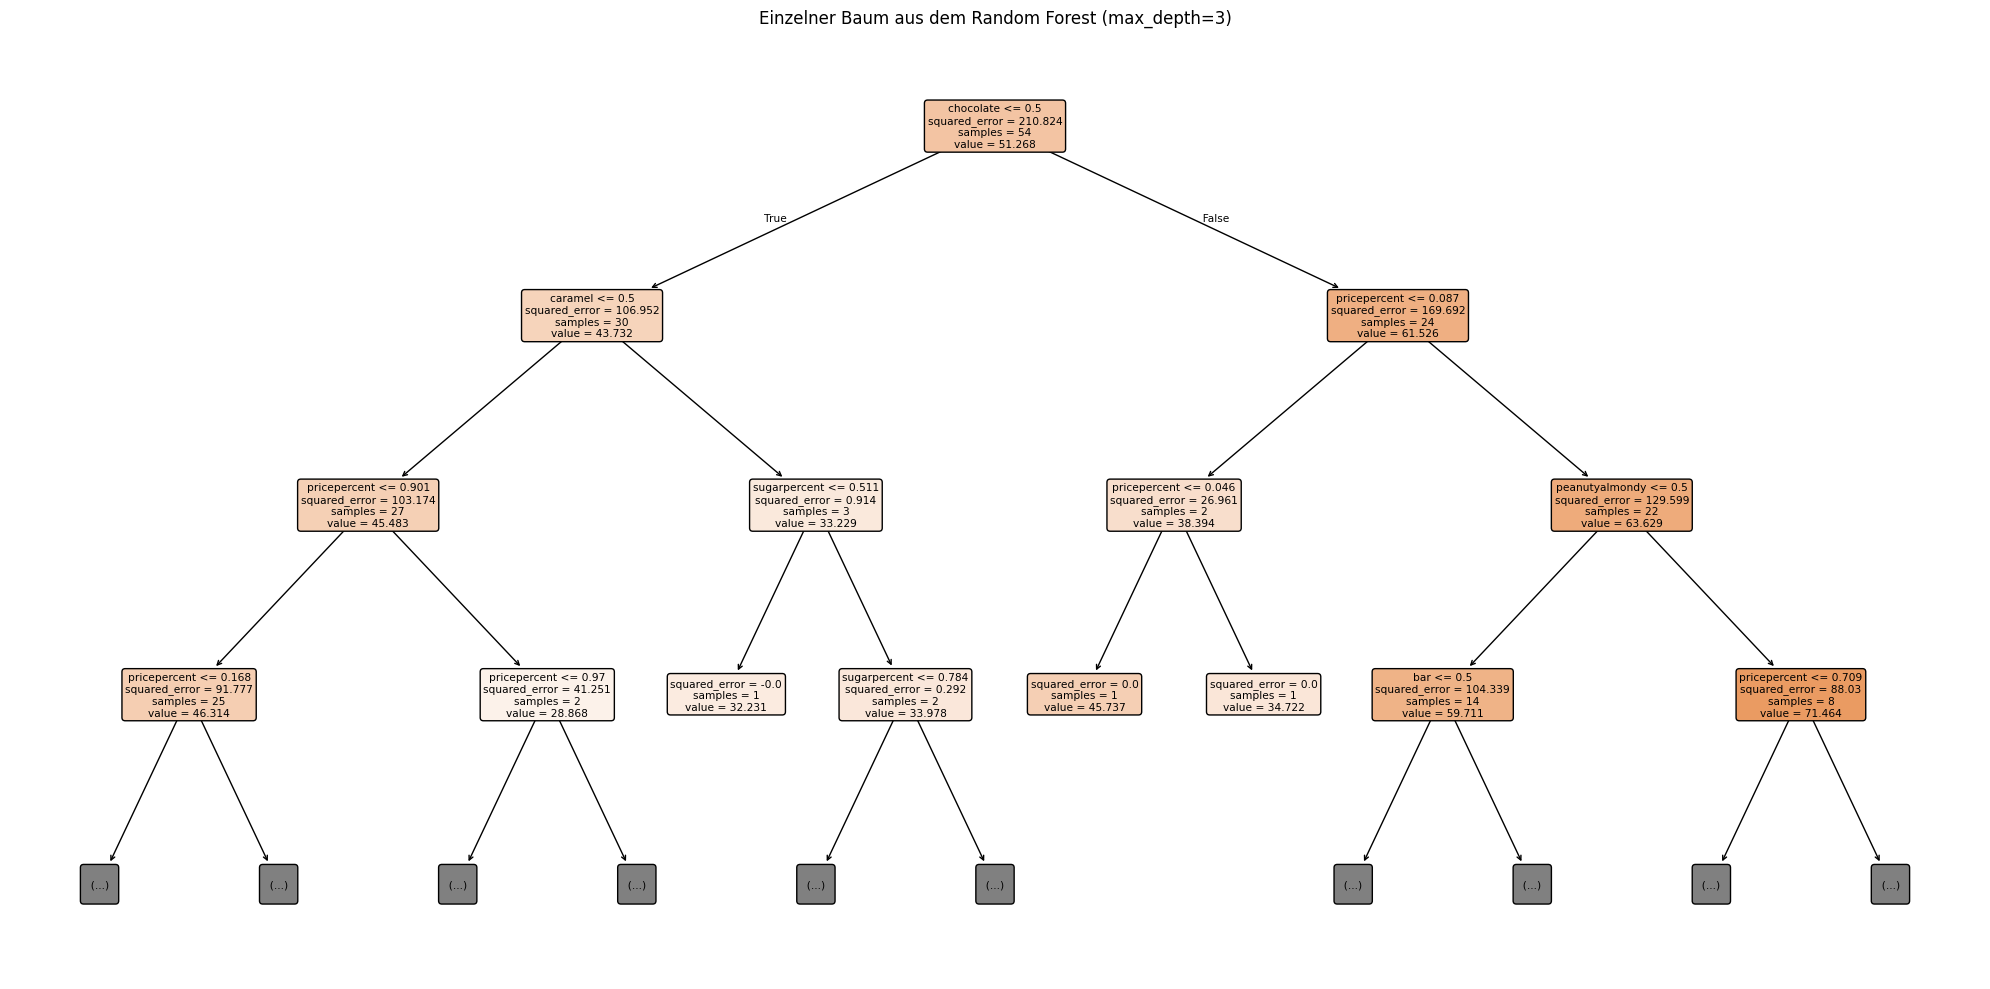

In [10]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error

cv = KFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestRegressor(random_state=42)

# R² scores per fold
r2_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='r2')
print("R² Scores (per fold):", r2_scores)
print("Mean R² Score:", np.mean(r2_scores))

# Cross-validated predictions for RMSE
y_pred_cv = cross_val_predict(rf_model, X, y, cv=cv)
rmse = mean_squared_error(y, y_pred_cv)
print("Cross-validated RMSE:", rmse)

# Plot predicted vs true
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y, y=y_pred_cv)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel("True Winpercent")
plt.ylabel("Predicted Winpercent")
plt.title("Cross-Validated Predictions vs. True Values")
plt.tight_layout()
plt.show()

# --- Fit RF on full data to get feature importances ---
rf_model.fit(X, y)
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

# --- Visualize one tree ---
plt.figure(figsize=(20, 10))
plot_tree(
    rf_model.estimators_[0],
    feature_names=X.columns,
    filled=True,
    max_depth=3,
    rounded=True
)
plt.title("Einzelner Baum aus dem Random Forest (max_depth=3)")
plt.tight_layout()
plt.show()

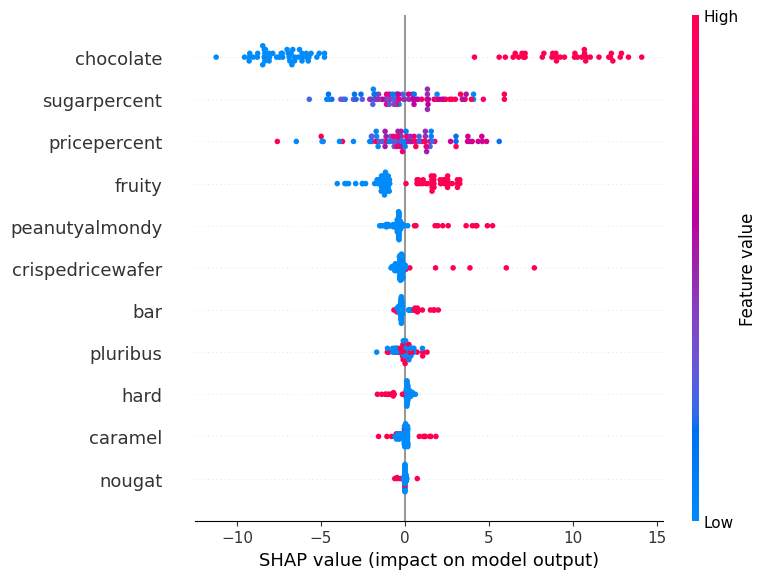

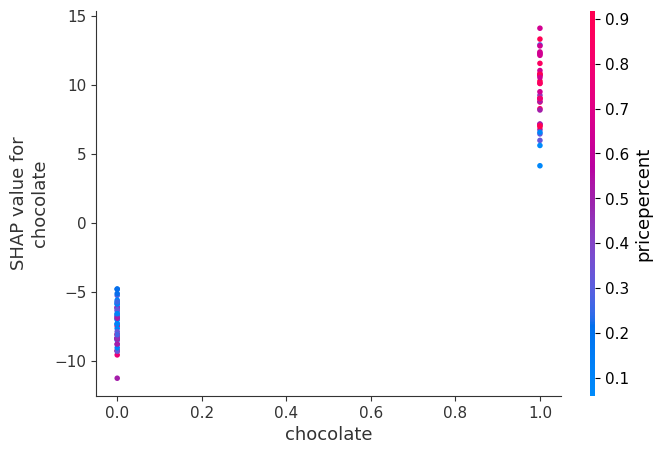

In [11]:
import shap

explainer_rf = shap.Explainer(rf_model, X)
shap_values_rf = explainer_rf(X)

shap.summary_plot(shap_values_rf, X)

shap.dependence_plot("chocolate", shap_values_rf.values, X)

### XGBOOST

XGBoost R² scores (5-fold): [-0.30256842  0.14414957  0.61180186  0.28163872  0.09918661]
Average R²: 0.16684166782806084
XGBoost RMSE scores (5-fold): [195.6905611  137.25387085  73.37079484 203.43299953 144.72363136]
Average RMSE: 150.894371537229


<Figure size 1000x600 with 0 Axes>

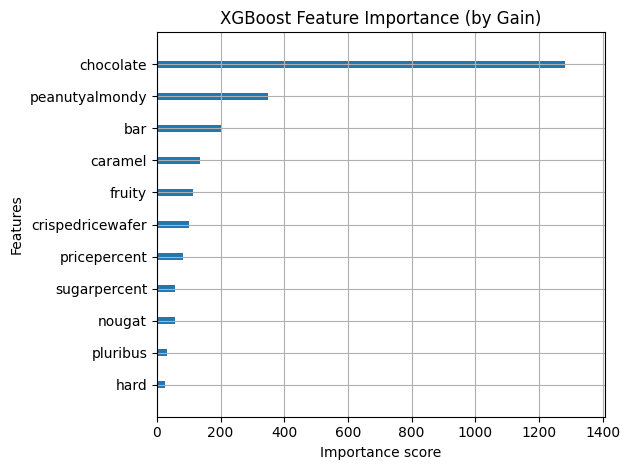

In [12]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)

# Cross-validation
cv_results = cross_validate(
    xgb_model,
    X,
    y,
    cv=5,
    scoring={'r2': 'r2', 'rmse': rmse_scorer},
    return_train_score=False
)

# Output results
print("XGBoost R² scores (5-fold):", cv_results['test_r2'])
print("Average R²:", np.mean(cv_results['test_r2']))
print("XGBoost RMSE scores (5-fold):", -cv_results['test_rmse'])  # Negate because it returns negative
print("Average RMSE:", -np.mean(cv_results['test_rmse']))

# Feature Importance
xgb_model.fit(X, y)

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='gain', show_values=False)
plt.title("XGBoost Feature Importance (by Gain)")
plt.tight_layout()
plt.show()

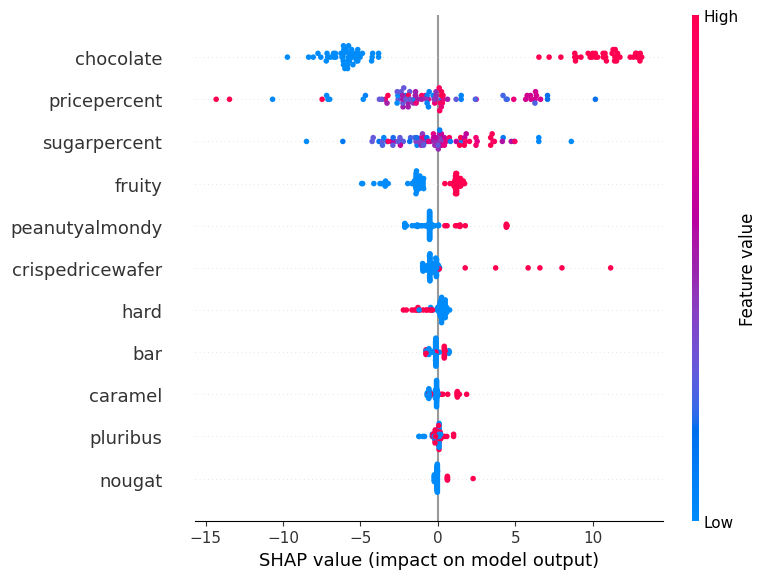

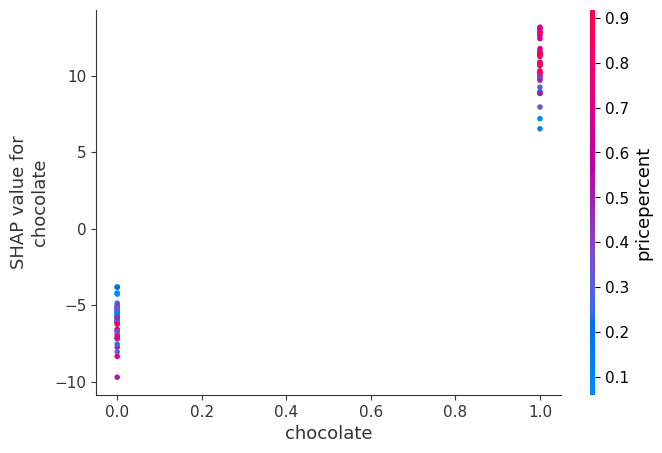

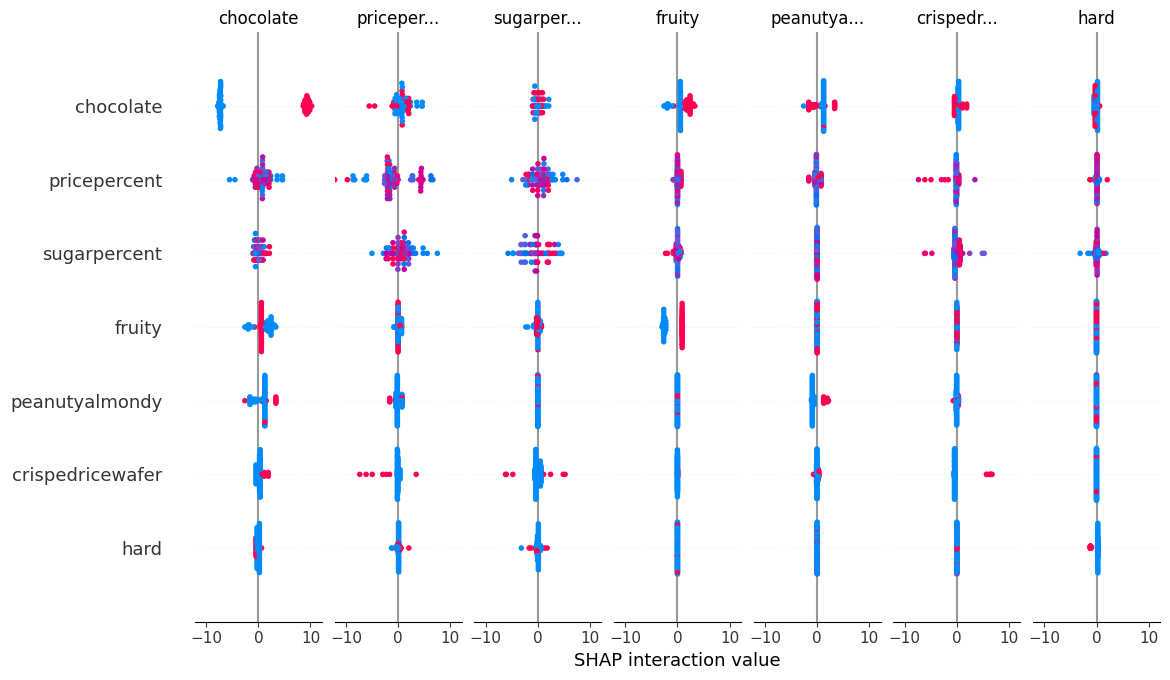

In [13]:
explainer_xgb = shap.Explainer(xgb_model)
shap_values_xgb = explainer_xgb(X)

# Summary Plot (bar + beeswarm)
shap.summary_plot(shap_values_xgb, X)

# Dependence Plot: visualize how 'chocolate' interacts with winpercent
shap.dependence_plot("chocolate", shap_values_xgb.values, X)

# Bonus: Interaction values
shap_interactions = shap.TreeExplainer(xgb_model).shap_interaction_values(X)
shap.summary_plot(shap_interactions, X)  # full interaction matrix

#### XGB - Interaction Effects 

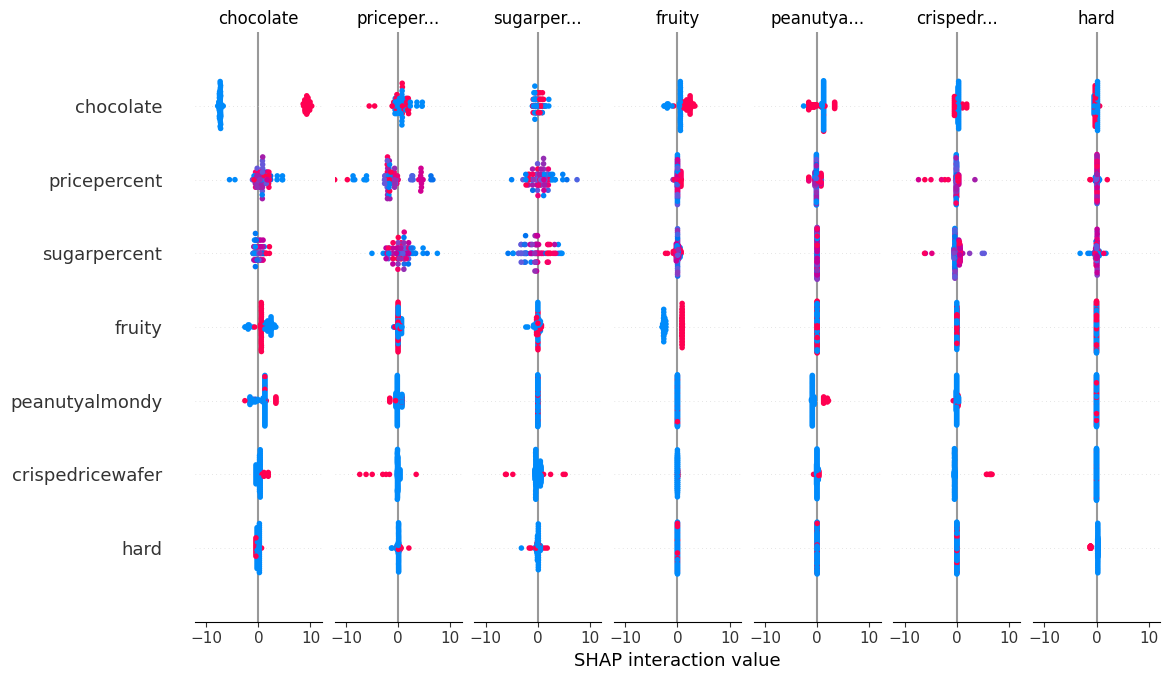

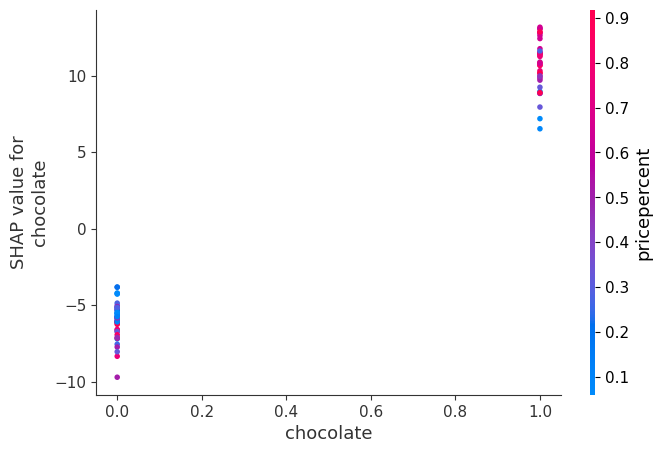

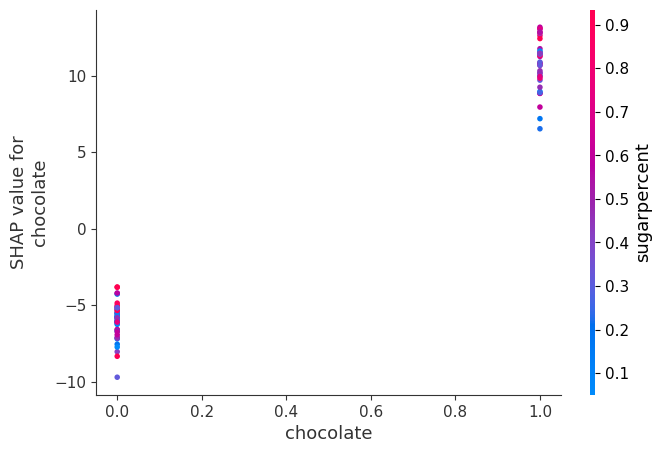

In [14]:
explainer = shap.TreeExplainer(xgb_model)
interaction_values = explainer.shap_interaction_values(X)

shap.summary_plot(interaction_values, X)  

shap.dependence_plot(
    'chocolate',  
    shap_values_xgb.values,
    X,
    interaction_index="pricepercent"  # force coloring by this second feature
)

shap.dependence_plot(
    'chocolate',  
    shap_values_xgb.values,
    X,
    interaction_index="sugarpercent"  # force coloring by this second feature
)

c:\Users\A77721724\priv\priv\repos\candy_case\.venv_candycase_analysis\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


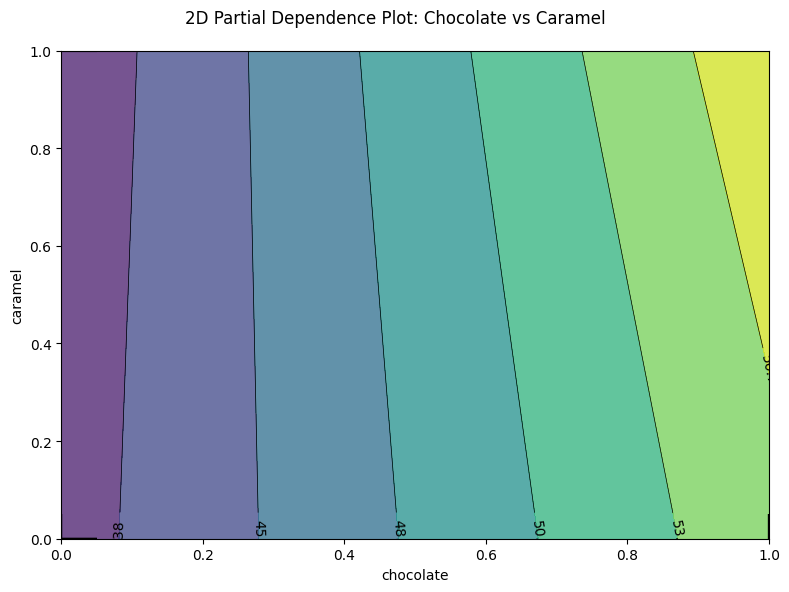

In [15]:
from sklearn.inspection import PartialDependenceDisplay

# For interaction between 'chocolate' and 'caramel'
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(
    xgb_model,
    X,
    [('chocolate', 'caramel')],  # tuple of two features
    ax=ax
)
plt.suptitle("2D Partial Dependence Plot: Chocolate vs Caramel")
plt.tight_layout()
plt.show()

### Additional Exploratory Plots

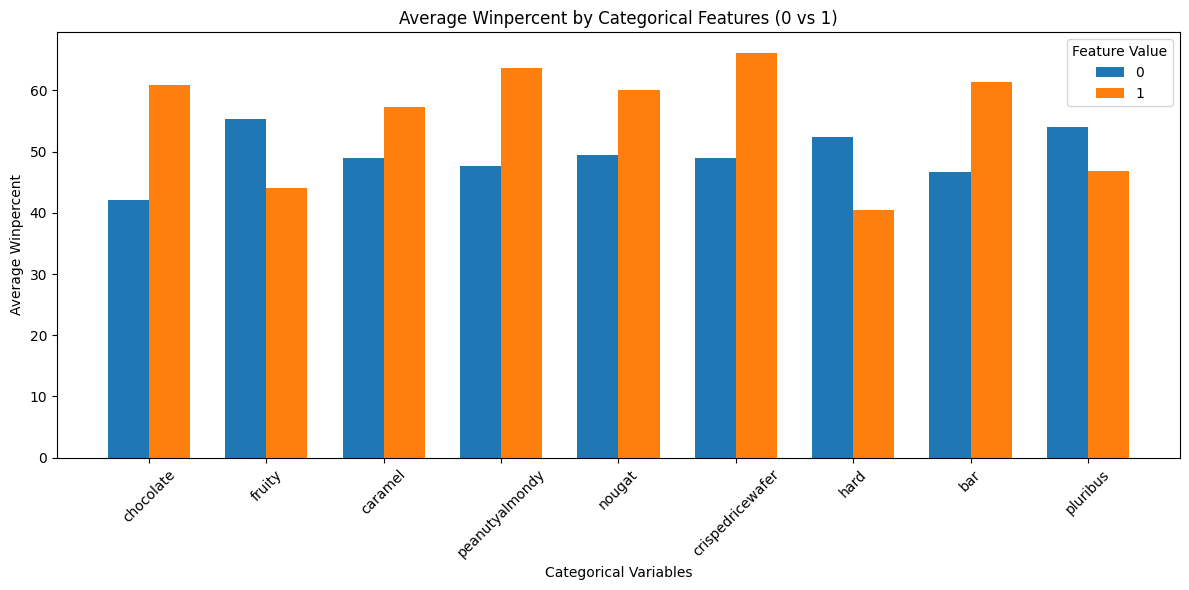

In [16]:
categorical_columns = [
    "chocolate", "fruity", "caramel", "peanutyalmondy",
    "nougat", "crispedricewafer", "hard", "bar", "pluribus"
]
importances_cat = importances[importances.index.isin(categorical_columns)]
categorical_columns = [x for x in categorical_columns if x in importances_cat.sort_values()[-9:].index]

# Calculate means for each categorical variable for 0 and 1
means_0 = []
means_1 = []
for col in categorical_columns:
    means_0.append(df[df[col] == 0]['winpercent'].mean())
    means_1.append(df[df[col] == 1]['winpercent'].mean())

# Positions on the x-axis
x = np.arange(len(categorical_columns))  # 0, 1, ..., 8

width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

bars_0 = ax.bar(x - width/2, means_0, width, label='0')
bars_1 = ax.bar(x + width/2, means_1, width, label='1')

# Labels and ticks
ax.set_xlabel('Categorical Variables')
ax.set_ylabel('Average Winpercent')
ax.set_title('Average Winpercent by Categorical Features (0 vs 1)')
ax.set_xticks(x)
ax.set_xticklabels(categorical_columns, rotation=45)
ax.legend(title='Feature Value')

plt.tight_layout()
plt.show()

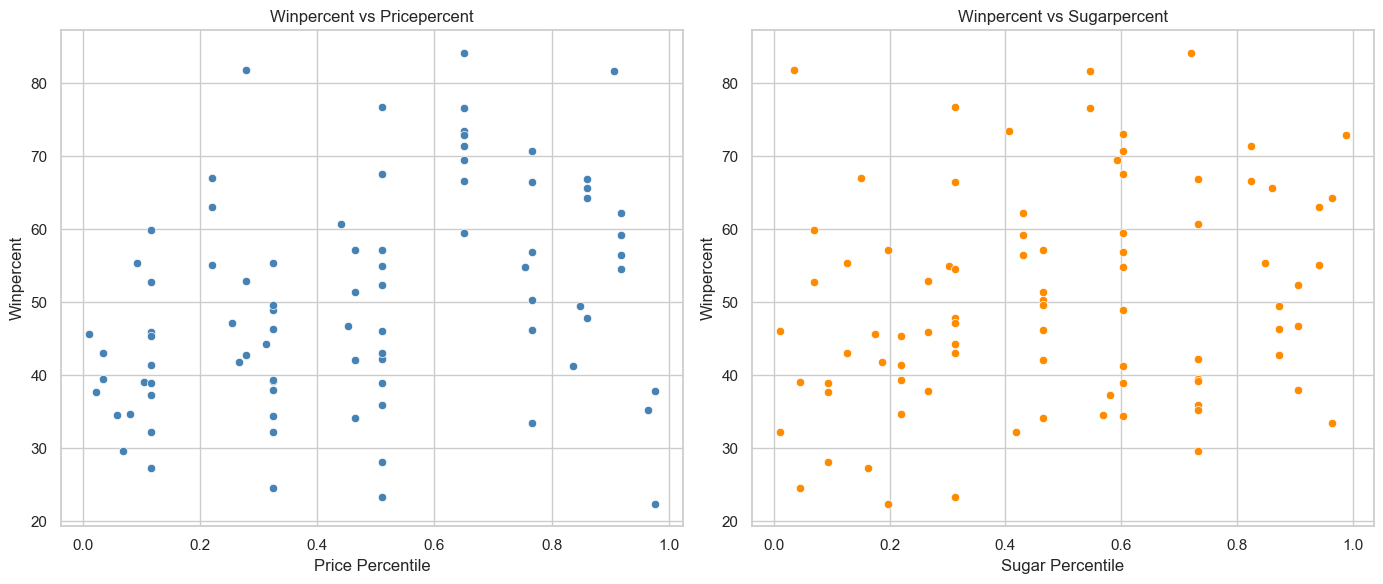

In [17]:
# Set style
sns.set(style="whitegrid")

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatterplot: winpercent vs pricepercent
sns.scatterplot(ax=axes[0], data=df, x="pricepercent", y="winpercent", color="steelblue")
axes[0].set_title("Winpercent vs Pricepercent")
axes[0].set_xlabel("Price Percentile")
axes[0].set_ylabel("Winpercent")

# Scatterplot: winpercent vs sugarpercent
sns.scatterplot(ax=axes[1], data=df, x="sugarpercent", y="winpercent", color="darkorange")
axes[1].set_title("Winpercent vs Sugarpercent")
axes[1].set_xlabel("Sugar Percentile")
axes[1].set_ylabel("Winpercent")

plt.tight_layout()
plt.show()

              winpercent  sugarpercent  pricepercent
winpercent      1.000000      0.229151      0.345325
sugarpercent    0.229151      1.000000      0.329706
pricepercent    0.345325      0.329706      1.000000


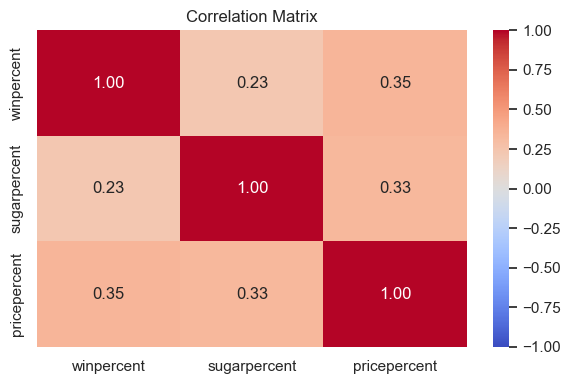

In [18]:
corr_cols = ["winpercent", "sugarpercent", "pricepercent"]
corr_matrix = df[corr_cols].corr()

# Print correlation matrix
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

### Cluster Analysis

Number of clusters: 2, Silhouette Score: 0.3732
Number of clusters: 3, Silhouette Score: 0.3512
Number of clusters: 4, Silhouette Score: 0.3326
Number of clusters: 5, Silhouette Score: 0.4027


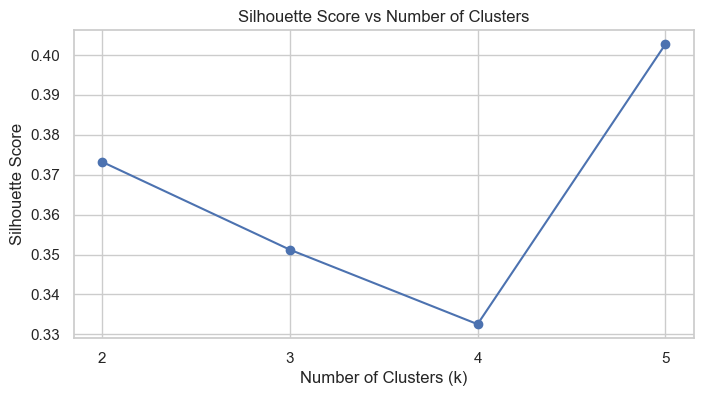


Optimal number of clusters: 5


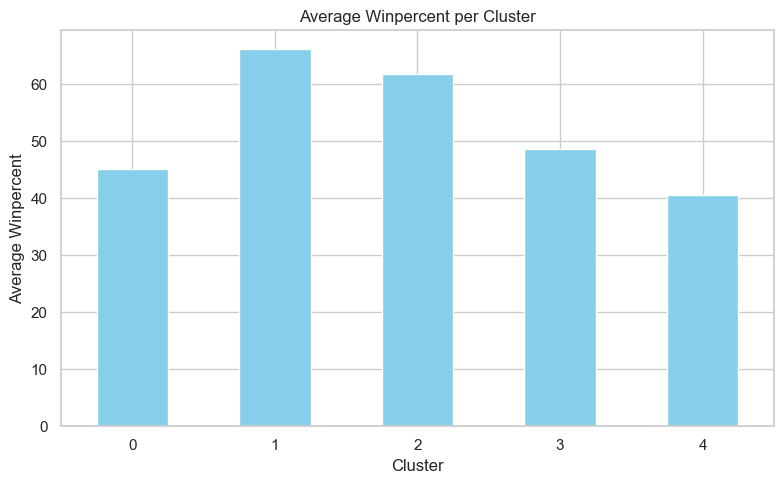


Cluster characteristics with sizes:
         chocolate  fruity  caramel  peanutyalmondy  nougat  crispedricewafer  \
cluster                                                                         
0            0.000   0.926    0.037           0.000   0.000               0.0   
1            1.000   0.000    0.429           0.143   0.000               1.0   
2            0.944   0.000    0.278           0.500   0.389               0.0   
3            0.667   0.000    0.222           0.222   0.000               0.0   
4            0.067   0.867    0.067           0.000   0.000               0.0   

         hard    bar  pluribus  size  
cluster                               
0         0.0  0.000     0.704    27  
1         0.0  0.857     0.143     7  
2         0.0  0.833     0.000    18  
3         0.0  0.000     0.889    18  
4         1.0  0.000     0.533    15  


In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("../candy-data.csv")

# Features for clustering (exclude target and non-feature cols)
features = df.drop(columns=['competitorname', 'winpercent', 'sugarpercent', 'pricepercent'])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Hyperparameter tuning: try cluster numbers from 3 to 7
sil_scores = []
cluster_range = range(2, 6)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f"Number of clusters: {k}, Silhouette Score: {score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

# Best k
best_k = cluster_range[np.argmax(sil_scores)]
print(f"\nOptimal number of clusters: {best_k}")

# Fit final model
kmeans_best = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = kmeans_best.fit_predict(X_scaled)

# Average winpercent per cluster
cluster_summary = df.groupby('cluster')['winpercent'].mean().sort_index()

# Plot average winpercent per cluster
plt.figure(figsize=(8, 5))
cluster_summary.plot(kind='bar', color='skyblue')
plt.title('Average Winpercent per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Winpercent')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Show cluster characteristics (mean of all features per cluster)
cluster_features = df.groupby('cluster')[features.columns].mean().round(3)

# Get cluster sizes
cluster_sizes = df['cluster'].value_counts().sort_index()

# Combine sizes and means into one DataFrame for better overview
cluster_summary_df = cluster_features.copy()
cluster_summary_df['size'] = cluster_sizes

print("\nCluster characteristics with sizes:")
print(cluster_summary_df)


In [20]:
cluster_features

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus
cluster,,,,,,,,,
0,0.000,0.926,0.037,0.000,0.000,0.0,0.0,0.000,0.704
1,1.000,0.000,0.429,0.143,0.000,1.0,0.0,0.857,0.143
2,0.944,0.000,0.278,0.500,0.389,0.0,0.0,0.833,0.000
3,0.667,0.000,0.222,0.222,0.000,0.0,0.0,0.000,0.889
4,0.067,0.867,0.067,0.000,0.000,0.0,1.0,0.000,0.533


In [23]:
df.winpercent.mean()

np.float64(50.316763811764716)